## Using different types of Gradient Boosting algorithms and their tuning

In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import loguniform

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes

In [46]:
housing_data = fetch_california_housing()
responseName = housing_data.target_names
featName = housing_data.feature_names
selcFeatName = ["MedInc", "AveOccup", "HouseAge", "AveRooms"]

X = pd.DataFrame(housing_data.data, columns=featName)
y = housing_data.target 

y_f = pd.DataFrame(housing_data.target, columns=responseName)
all_data=pd.concat([X,y_f], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [57]:
clf = XGBRegressor(random_state=0)
scoring="neg_root_mean_squared_error"
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.941591449518716
0.8322389144404666


#### Types of hyper-param search
- Grid Search: GridSearchCV (model, parameter grid, scoring, cv, verbose, refit)
- Randomized Search: RandomizedSearchCV
- Bayesian Search: 
- dont know of any way to combine early stopping with hyper-param search

In [58]:

param_grid = {
    "n_estimators": [10, 20, 50],
}
search_cv = GridSearchCV(clf, param_grid=param_grid, scoring=scoring)
search_cv.fit(X_train, y_train)

columns = [f"param_{name}" for name in param_grid.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,mean_test_error,std_test_error
2,50,0.490440,0.010451
1,20,0.508535,0.007694
0,10,0.542862,0.009465


#### Early stopping
- Using xgboost native functions, so eval_metric uses evaluation metrics specific to XGBoost

[0]	validation_0-rmse:1.44796	validation_1-rmse:1.43538
[1]	validation_0-rmse:1.10977	validation_1-rmse:1.10958
[2]	validation_0-rmse:0.88607	validation_1-rmse:0.89705
[3]	validation_0-rmse:0.74083	validation_1-rmse:0.76170
[4]	validation_0-rmse:0.64646	validation_1-rmse:0.67791
[5]	validation_0-rmse:0.59077	validation_1-rmse:0.63082
[6]	validation_0-rmse:0.55518	validation_1-rmse:0.60121
[7]	validation_0-rmse:0.52860	validation_1-rmse:0.57819
[8]	validation_0-rmse:0.50847	validation_1-rmse:0.56259
[9]	validation_0-rmse:0.49044	validation_1-rmse:0.54638
[10]	validation_0-rmse:0.47939	validation_1-rmse:0.53786
[11]	validation_0-rmse:0.47372	validation_1-rmse:0.53494
[12]	validation_0-rmse:0.46331	validation_1-rmse:0.52576
[13]	validation_0-rmse:0.45567	validation_1-rmse:0.52425
[14]	validation_0-rmse:0.44877	validation_1-rmse:0.52062
[15]	validation_0-rmse:0.44211	validation_1-rmse:0.51648
[16]	validation_0-rmse:0.43666	validation_1-rmse:0.51524
[17]	validation_0-rmse:0.43287	validation

/Users/parulpandey/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/parulpandey/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-rmse:0.39865	validation_1-rmse:0.49665
[26]	validation_0-rmse:0.39424	validation_1-rmse:0.49469
[27]	validation_0-rmse:0.39197	validation_1-rmse:0.49309
[28]	validation_0-rmse:0.39085	validation_1-rmse:0.49227
[29]	validation_0-rmse:0.38746	validation_1-rmse:0.49095
[30]	validation_0-rmse:0.38548	validation_1-rmse:0.49061
[31]	validation_0-rmse:0.38426	validation_1-rmse:0.49071
[32]	validation_0-rmse:0.37950	validation_1-rmse:0.48714
[33]	validation_0-rmse:0.37641	validation_1-rmse:0.48624
[34]	validation_0-rmse:0.37363	validation_1-rmse:0.48511
[35]	validation_0-rmse:0.37061	validation_1-rmse:0.48491
[36]	validation_0-rmse:0.36917	validation_1-rmse:0.48494
[37]	validation_0-rmse:0.36748	validation_1-rmse:0.48407
[38]	validation_0-rmse:0.36659	validation_1-rmse:0.48430
[39]	validation_0-rmse:0.36378	validation_1-rmse:0.48300
[40]	validation_0-rmse:0.36135	validation_1-rmse:0.48358
[41]	validation_0-rmse:0.36015	validation_1-rmse:0.48369
[42]	validation_0-rmse:0.35830	

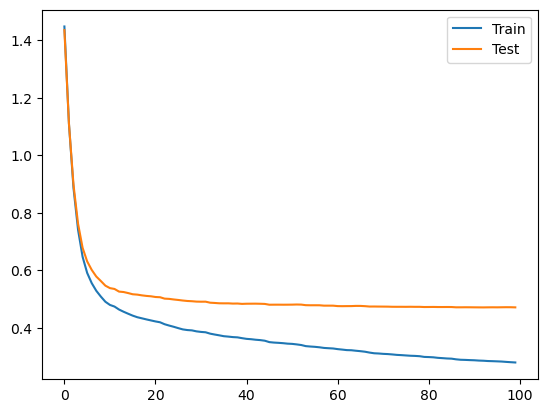

In [62]:
clf = XGBRegressor()
eval_test = [(X_train, y_train), (X_test, y_test)]
clf.fit(X_train, y_train, eval_set=eval_test, eval_metric=['rmse'], early_stopping_rounds=10, verbose=True)
results = clf.evals_result()
epochs = len(results['validation_0']['rmse'])
fig, ax = plt.subplots()
ax.plot(range(0, epochs), results['validation_0']['rmse'], label='Train')
ax.plot(range(0, epochs), results['validation_1']['rmse'], label='Test')
ax.legend()

#### References

- https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html